 # **Modelos de Clasificación: Logístico, Ridge y Lasso**

 Comparativa de tres modelos de clasificación.

In [1]:
# --- IMPORTACIÓN DE LIBRERÍAS ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score
)
from sklearn.compose import ColumnTransformer

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("Set2")


In [2]:
# --- 1. CARGA Y PREPARACIÓN DE DATOS ---
# Cargar dataset de pacientes diabéticos
dflog = pd.read_csv('diabetic_data.csv')

# Crear variable objetivo binaria: 1 si reingresa (<30 o >30 días), 0 si no reingresa
dflog['target'] = dflog['readmitted'].isin(['<30', '>30']).astype(int)

# Eliminar columnas irrelevantes o con muchos valores faltantes
columnas_eliminar = ['encounter_id', 'patient_nbr', 'readmitted', 'weight', 'payer_code', 'medical_specialty']
dflog = dflog.drop(columns=columnas_eliminar)

# Separar características (X) y variable objetivo (y)
X = dflog.drop('target', axis=1)
y = dflog['target']

# Dividir datos en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [3]:
# --- 2. PREPROCESAMIENTO DE DATOS ---
# Identificar tipos de columnas para aplicar transformaciones adecuadas
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Configurar de preprocesamiento:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Ajustar preprocesador SOLO con datos de entrenamiento para evitar data leakage
print("Ajustando el preprocesador con los datos de entrenamiento...")
preprocessor.fit(X_train)

# Transformar ambos conjuntos con el preprocesador ajustado
print("Transformando los datos de entrenamiento y prueba...")
X_train_procesado = preprocessor.transform(X_train)
X_test_procesado = preprocessor.transform(X_test)


Ajustando el preprocesador con los datos de entrenamiento...
Transformando los datos de entrenamiento y prueba...


In [4]:
# --- 3. MODELO REGRESIÓN LOGÍSTICA CON GRIDSEARCH ---

print("\n" + "="*50)
print("ENTRENANDO MODELO LOGÍSTICO")
print("="*50)

# Definir hiperparámetros para optimizar con validación cruzada
logistic_param_grid = {
    'C': [0.1, 1, 10, 100],  # Parámetro de regularización (inverso de la fuerza)
    'max_iter': [1000]       # Máximo número de iteraciones para converger
}

# Configurar búsqueda en grilla con validación cruzada de 5 folds
logistic_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=logistic_param_grid,
    cv=5,                    # 5-fold cross validation
    scoring='accuracy',      # Métrica de evaluación
    n_jobs=-1,               # Usar todos los núcleos del CPU
    verbose=1                # Mostrar progreso
)

# Entrenar modelo con búsqueda de mejores parámetros
logistic_grid.fit(X_train_procesado, y_train)

# Obtener mejor modelo y realizar predicciones
best_logistic = logistic_grid.best_estimator_
y_pred_logistic = best_logistic.predict(X_test_procesado)
y_pred_proba_logistic = best_logistic.predict_proba(X_test_procesado)[:, 1]



ENTRENANDO MODELO LOGÍSTICO
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [5]:
# --- 4. MODELO RIDGE CLASSIFIER CON GRIDSEARCH ---

print("\n" + "="*50)
print("ENTRENANDO MODELO RIDGE")
print("="*50)

# Definir hiperparámetros para Ridge Classifier
ridge_param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Parámetro de regularización (fuerza)
    'solver': ['auto'],          # Algoritmo de optimización
    'max_iter': [1000]           # Máximo número de iteraciones
}

# Configurar búsqueda en grilla para Ridge
ridge_grid = GridSearchCV(
    RidgeClassifier(random_state=42),
    param_grid=ridge_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entrenar modelo Ridge
ridge_grid.fit(X_train_procesado, y_train)

# Obtener y evaluar mejor modelo Ridge
best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test_procesado)

# Ridge no tiene predict_proba por defecto, usar decisión function para curva ROC
y_decision_ridge = best_ridge.decision_function(X_test_procesado)



ENTRENANDO MODELO RIDGE
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [6]:
# --- 5. MODELO LASSO CON GRIDSEARCH ---

print("\n" + "="*50)
print("ENTRENANDO MODELO LASSO")
print("="*50)

# Definir hiperparámetros para Lasso
lasso_param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Parámetro de regularización
    'max_iter': [1000]           # Máximo número de iteraciones
}

# Configurar búsqueda en grilla para Lasso (usando R² como métrica)
lasso_grid = GridSearchCV(
    Lasso(random_state=42, tol=0.001),
    param_grid=lasso_param_grid,
    cv=5,
    scoring='r2',                # R² para problema de regresión
    n_jobs=-1,
    verbose=1
)

# Entrenar modelo Lasso (regresión)
lasso_grid.fit(X_train_procesado, y_train)

# Obtener mejor modelo Lasso
best_lasso = lasso_grid.best_estimator_

# Predecir valores continuos (regresión) y convertir a clasificación
y_pred_lasso_continuous = best_lasso.predict(X_test_procesado)
y_pred_lasso = (y_pred_lasso_continuous > 0.5).astype(int)



ENTRENANDO MODELO LASSO
Fitting 5 folds for each of 4 candidates, totalling 20 fits



MATRICES DE CONFUSIÓN


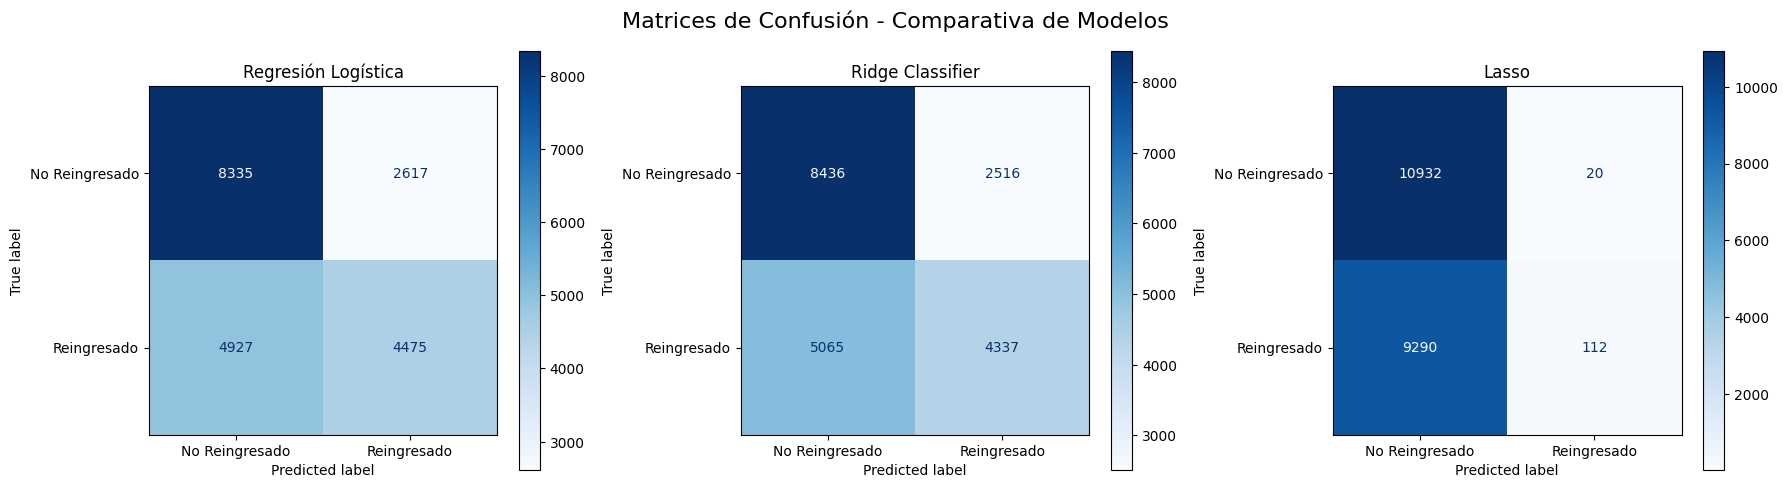

In [11]:
# --- 6. MATRICES DE CONFUSIÓN PARA TODOS LOS MODELOS ---

print("\n" + "="*50)
print("MATRICES DE CONFUSIÓN")
print("="*50)

# Crear figura con subplots para las matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Matrices de Confusión - Comparativa de Modelos', fontsize=16)

# Matriz de confusión para Regresión Logística
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic,
                                      display_labels=['No Reingresado', 'Reingresado'])
disp_logistic.plot(ax=axes[0], cmap="Blues")
axes[0].set_title('Regresión Logística')

# Matriz de confusión para Ridge
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
disp_ridge = ConfusionMatrixDisplay(confusion_matrix=cm_ridge,
                                   display_labels=['No Reingresado', 'Reingresado'])
disp_ridge.plot(ax=axes[1], cmap="Blues")
axes[1].set_title('Ridge Classifier')

# Matriz de confusión para Lasso
cm_lasso = confusion_matrix(y_test, y_pred_lasso)
disp_lasso = ConfusionMatrixDisplay(confusion_matrix=cm_lasso,
                                   display_labels=['No Reingresado', 'Reingresado'])
disp_lasso.plot(ax=axes[2], cmap="Blues")
axes[2].set_title('Lasso')

plt.tight_layout()
plt.show()



CURVAS ROC


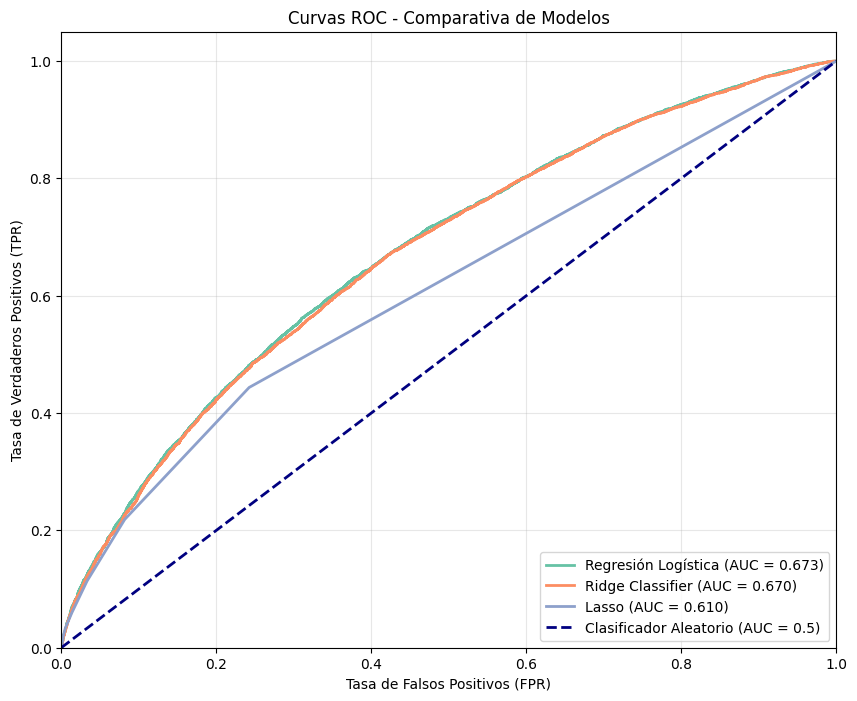

In [8]:
# --- 7. CURVAS ROC PARA TODOS LOS MODELOS ---

print("\n" + "="*50)
print("CURVAS ROC")
print("="*50)

# Crear figura para curvas ROC
plt.figure(figsize=(10, 8))

# Curva ROC para Regresión Logística
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)
plt.plot(fpr_logistic, tpr_logistic, lw=2,
         label=f'Regresión Logística (AUC = {roc_auc_logistic:.3f})')

# Curva ROC para Ridge (usando decision function)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, y_decision_ridge)
roc_auc_ridge = auc(fpr_ridge, tpr_ridge)
plt.plot(fpr_ridge, tpr_ridge, lw=2,
         label=f'Ridge Classifier (AUC = {roc_auc_ridge:.3f})')

# Curva ROC para Lasso (usando valores continuos)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_pred_lasso_continuous)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)
plt.plot(fpr_lasso, tpr_lasso, lw=2,
         label=f'Lasso (AUC = {roc_auc_lasso:.3f})')

# Línea de referencia (clasificador aleatorio)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio (AUC = 0.5)')

# Configurar gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC - Comparativa de Modelos')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# --- 8. TABLA COMPARATIVA CON MÉTRICAS DETALLADAS ---

print("\n" + "="*50)
print("TABLA COMPARATIVA DE MÉTRICAS")
print("="*50)

# Calcular métricas para cada modelo
def calcular_metricas(y_true, y_pred, y_score=None, modelo_nombre=""):
    """Calcula múltiples métricas de evaluación para un modelo"""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred)
    }

    # Calcular AUC si hay scores disponibles
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        metrics['AUC'] = auc(fpr, tpr)
    else:
        metrics['AUC'] = None

    return metrics

# Calcular métricas para cada modelo
metricas_logistic = calcular_metricas(y_test, y_pred_logistic, y_pred_proba_logistic, "Logístico")
metricas_ridge = calcular_metricas(y_test, y_pred_ridge, y_decision_ridge, "Ridge")
metricas_lasso = calcular_metricas(y_test, y_pred_lasso, y_pred_lasso_continuous, "Lasso")

# Crear DataFrame comparativo
comparativa_df = pd.DataFrame({
    'Regresión Logística': metricas_logistic,
    'Ridge Classifier': metricas_ridge,
    'Lasso': metricas_lasso
}).T

# Formatear valores para mejor visualización
for col in comparativa_df.columns:
    if comparativa_df[col].dtype == 'float64':
        comparativa_df[col] = comparativa_df[col].round(4)

print("Comparativa de Métricas en Conjunto de Prueba:")
print(comparativa_df)

# Mostrar mejor modelo por cada métrica
print("\n" + "="*50)
print("MEJOR MODELO POR MÉTRICA")
print("="*50)

for metrica in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']:
    if metrica in comparativa_df.columns:
        mejor_valor = comparativa_df[metrica].max()
        mejor_modelo = comparativa_df[comparativa_df[metrica] == mejor_valor].index[0]
        print(f"{metrica}: {mejor_modelo} ({mejor_valor:.4f})")



TABLA COMPARATIVA DE MÉTRICAS
Comparativa de Métricas en Conjunto de Prueba:
                     Accuracy  Precision  Recall  F1-Score     AUC
Regresión Logística    0.6294     0.6310  0.4760    0.5426  0.6728
Ridge Classifier       0.6275     0.6329  0.4613    0.5336  0.6699
Lasso                  0.5426     0.8485  0.0119    0.0235  0.6103

MEJOR MODELO POR MÉTRICA
Accuracy: Regresión Logística (0.6294)
Precision: Lasso (0.8485)
Recall: Regresión Logística (0.4760)
F1-Score: Regresión Logística (0.5426)
AUC: Regresión Logística (0.6728)


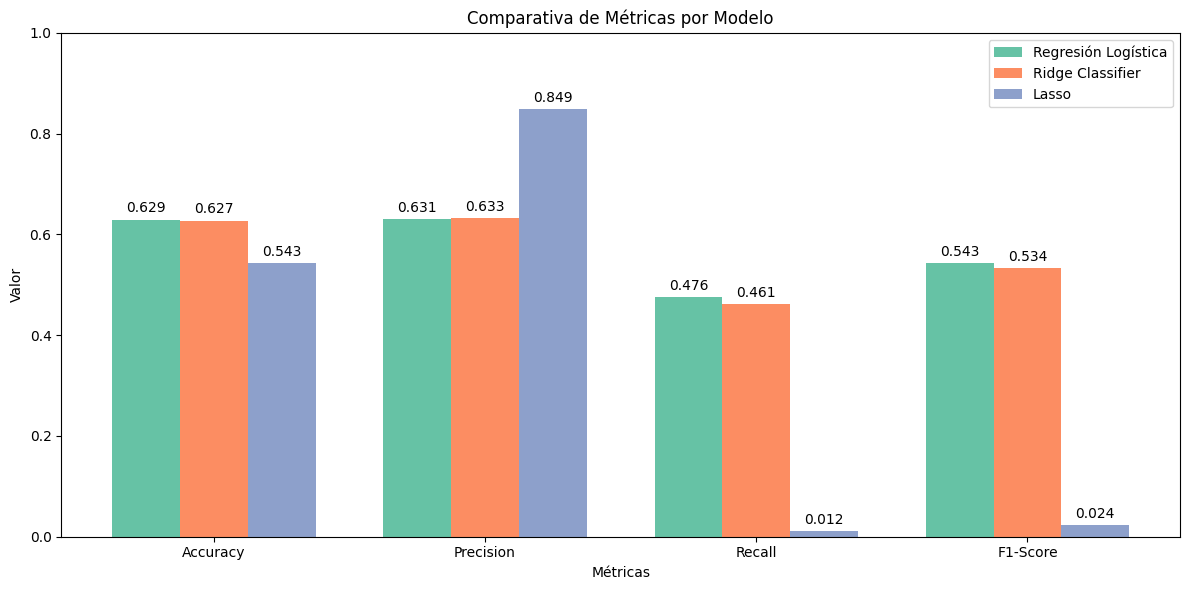

In [10]:
# --- 9. VISUALIZACIÓN COMPARATIVA DE MÉTRICAS ---

# Crear gráfico de barras comparativo
metricas_grafico = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, ax = plt.subplots(figsize=(12, 6))

# Ancho de las barras
x = np.arange(len(metricas_grafico))
width = 0.25

# Crear barras para cada modelo
rects1 = ax.bar(x - width, comparativa_df.loc['Regresión Logística'][metricas_grafico],
                width, label='Regresión Logística')
rects2 = ax.bar(x, comparativa_df.loc['Ridge Classifier'][metricas_grafico],
                width, label='Ridge Classifier')
rects3 = ax.bar(x + width, comparativa_df.loc['Lasso'][metricas_grafico],
                width, label='Lasso')

# Configurar gráfico
ax.set_xlabel('Métricas')
ax.set_ylabel('Valor')
ax.set_title('Comparativa de Métricas por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(metricas_grafico)
ax.legend()
ax.set_ylim(0, 1)

# Añadir valores en las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


In [ ]:
# --- 10. RESUMEN FINAL ---

print("\n" + "="*50)
print("RESUMEN EJECUTIVO")
print("="*50)

# Identificar el mejor modelo general (mayor AUC)
mejor_modelo_auc = comparativa_df['AUC'].idxmax()
mejor_auc = comparativa_df.loc[mejor_modelo_auc, 'AUC']

print(f"Mejor modelo general (mayor AUC): {mejor_modelo_auc} (AUC = {mejor_auc:.4f})")

# Mostrar distribución de clases para contexto
print(f"\nDistribución de clases en variable objetivo:")
print(y.value_counts())
print(f"Proporción clase positiva: {y.mean():.3f}")


RESUMEN EJECUTIVO
Mejor modelo general (mayor AUC): Regresión Logística (AUC = 0.6728)

Distribución de clases en variable objetivo:
target
0    54864
1    46902
Name: count, dtype: int64
Proporción clase positiva: 0.461


## Conclusiones.

**Panorama:** Mejora marginal vs KNN, pero rendimiento clínicamente inaceptable. Ningún modelo alcanza estándar médico operacional.

### Análisis por Modelo

**Regresión Logística & Ridge:**
- Recall ~47%: **Pierden >50% casos críticos** - inaceptable para setting hospitalario
- Precision ~63%: Genera falsas alarmas masivas (2,500+ FP)
- AUC 0.67: Capacidad discriminativa **débil** - límite de modelos lineales alcanzado

**Lasso:**
- **Error conceptual:** `scoring='r2'` para clasificación → modelo regresivo forzado
- Recall 1.2%: Virtualmente ciego a casos positivos
- Precision 85%: **Espejismo estadístico** - conservadurismo extremo por L1

### Posibles mejoras

1. **Cambio de objetivo:** `readmitted` ∈ ['<30', '>30'] contamina señal específica <30 días
2. **Límite arquitectural:** Relaciones lineales insuficientes para complejidad médica
3. **Métrica persistente:** `scoring='accuracy'` sigue saboteando optimización

### Plan a futuro

**Estratégico:**
- Feature engineering: interacciones entre medicamentos, agrupación de diagnósticos.
- Threshold optimization vía Precision-Recall curves.

> **Conclusión:** Modelos lineales han alcanzado techo de performance. **Escalamiento no-lineal obligatorio** para viabilidad clínica.